In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import sys
sys.path.append("../")

In [95]:
import numpy as np
from dowhy import gcm
from dowhy.utils import plot
import matplotlib.pyplot as plt 

from src.utils import load_model
from src.causal_graph import causal_graph

In [96]:
def plot_ate_with_confidence(ate_data):
    regions = list(ate_data['ate'].keys())
    ate_values = [ate_data['ate'][region]['median'] for region in regions]
    lower_bounds = [ate_data['ate'][region]['interval'][0] for region in regions]
    upper_bounds = [ate_data['ate'][region]['interval'][1] for region in regions]

    fig, ax = plt.subplots()
    y_pos = np.arange(len(regions))


    ax.errorbar(ate_values, y_pos, xerr=[np.array(ate_values) - np.array(lower_bounds), np.array(upper_bounds) - np.array(ate_values)],
                fmt='o', color='black', capsize=5, markersize=5)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(regions)
    ax.axvline(x=0, color='gray', linestyle='--')
    ax.set_xlabel('ATE')
    ax.set_title('Average Treatment Effect (ATE) with Confidence Intervals')
    plt.show()

def construct_ate_exposition_dict(exposition_classes, ref_value):
    ate_exposition_dict = {"ref_value": ref_value, "ate": {}}  
    for region in exposition_classes:
        ate_exposition_dict["ate"][region] = {}
    return ate_exposition_dict

def get_ate_with_confidence_for_factor_classes(ate_dict: dict, factor_name: str):
    for cl in ate_dict["ate"].keys():
        effect_median, effect_interval = gcm.confidence_intervals(
            gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                causal_model, "fire", 
                                interventions_alternative={factor_name: lambda x: cl},
                                interventions_reference={factor_name: lambda x: ate_dict["ref_value"]}, 
                                num_samples_to_draw=1000))
        ate_dict["ate"][cl]["median"] = effect_median[0]
        ate_dict["ate"][cl]["interval"] = effect_interval[0]
    return ate_dict

In [97]:
causal_model, causal_mechanisms_summary, eval_summary = load_model(r"../models/model_v1.pkl")

### Estimating direct causal impact of each factor

In [98]:
def convert_to_percentage(value_dictionary):
    total_absolute_sum = np.sum([abs(v) for v in value_dictionary.values()])
    return {k: abs(v) / total_absolute_sum * 100 for k, v in value_dictionary.items()}

In [99]:
strength_median, strength_intervals = gcm.confidence_intervals(
    gcm.bootstrap_sampling(gcm.arrow_strength,
                           causal_model,
                           target_node='fire'))

print(strength_median)
print(strength_intervals)

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:45<00:00,  2.29s/it]

{('exposition', 'fire'): 0.00526882433202343, ('ffmc', 'fire'): 0.3575274040407897, ('forest_coverage', 'fire'): 0.0019984115151731887, ('forest_type', 'fire'): 0.0031323264144378637}
{('exposition', 'fire'): array([0.00434739, 0.0058584 ]), ('ffmc', 'fire'): array([0.30981182, 0.39664732]), ('forest_coverage', 'fire'): array([0.00167154, 0.00254283]), ('forest_type', 'fire'): array([0.00244736, 0.00391386])}


{('exposition', 'fire'): 1.4320299446854419, ('ffmc', 'fire'): 97.17347103797596, ('forest_coverage', 'fire'): 0.54315440242305, ('forest_type', 'fire'): 0.8513446149155569}


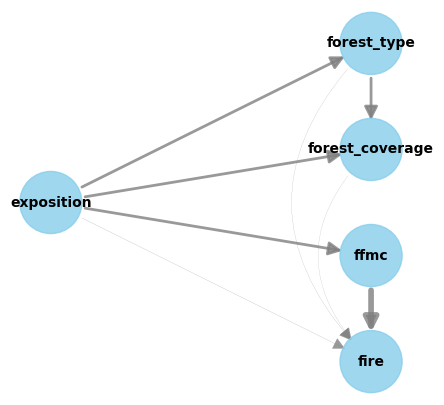

In [100]:
print(convert_to_percentage(strength_median))
plot(causal_graph, causal_strengths=convert_to_percentage(strength_median))

### Estimating causal effects of classes 

In [101]:
forest_cover_classes = ["cc<=20", "20<cc<=40", "40<cc<=60", "60<cc<=80", "cc>80"]
exposition_classes = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
foret_type_classes = ["coniferous non pine", "coniferous with mixed pine", "pine pure", 
                      "coniferous deciduous mixed with pine", "coniferous deciduous mixed non pine", "deciduous pure", "low and no vegetation"]
ffmc_classes = ["ffmc<78", "78<=ffmc<87", "87<=ffmc<91", "91<=ffmc<93", "ffmc>=93"]

ate_forest_cover_dict = construct_ate_exposition_dict(forest_cover_classes, "40<cc<=60")
ate_exposition_dict = construct_ate_exposition_dict(exposition_classes, "E")
ate_foret_type_dict = construct_ate_exposition_dict(foret_type_classes, "coniferous non pine")
ate_ffmc_classes_dict = construct_ate_exposition_dict(ffmc_classes, "ffmc<78")

In [102]:
def get_ate_with_confidence_for_factor_classes(ate_dict: dict, factor_name: str):
    for cl in ate_dict["ate"].keys():
        effect_median, effect_interval = gcm.confidence_intervals(
            gcm.bootstrap_sampling(gcm.average_causal_effect, 
                                causal_model, "fire", 
                                interventions_alternative={factor_name: lambda x: cl},
                                interventions_reference={factor_name: lambda x: ate_dict["ref_value"]}, 
                                num_samples_to_draw=1000))
        ate_dict["ate"][cl]["median"] = effect_median[0]
        ate_dict["ate"][cl]["interval"] = effect_interval[0]
    return ate_dict

In [104]:
ate_forest_cover_dict = get_ate_with_confidence_for_factor_classes(ate_forest_cover_dict, "forest_coverage")
ate_exposition_dict = get_ate_with_confidence_for_factor_classes(ate_exposition_dict, "exposition")
ate_foret_type_dict = get_ate_with_confidence_for_factor_classes(ate_foret_type_dict, "forest_type")

Estimating bootstrap interval...: 100%|██████████| 20/20 [00:01<00:00, 11.02it/s]


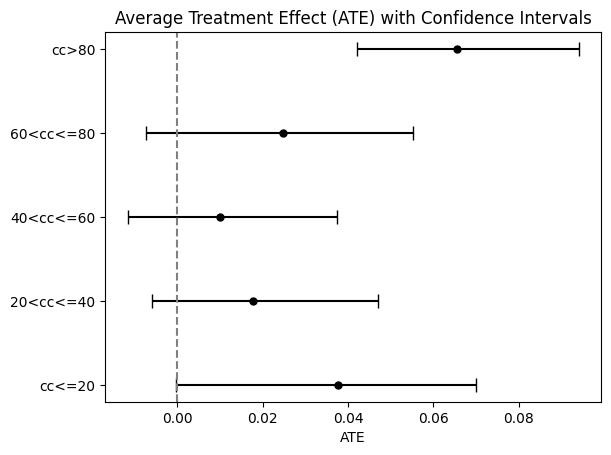

In [105]:
plot_ate_with_confidence(ate_forest_cover_dict)

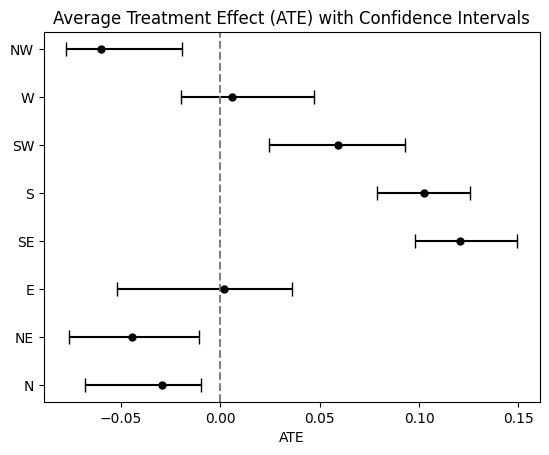

In [106]:
plot_ate_with_confidence(ate_exposition_dict)

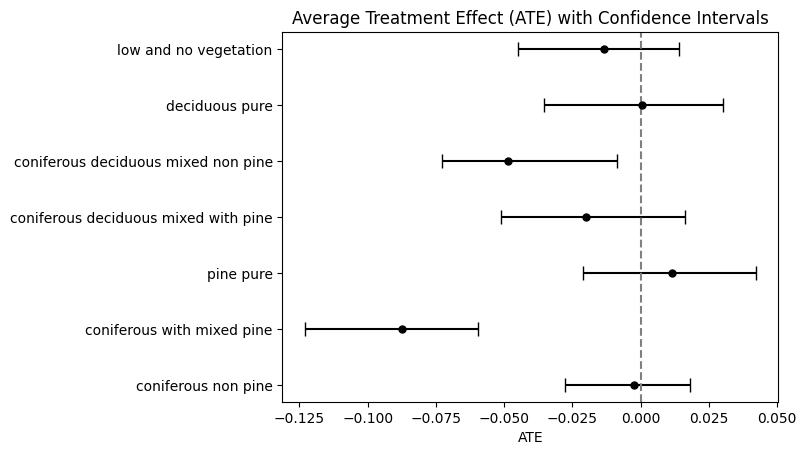

In [107]:
plot_ate_with_confidence(ate_foret_type_dict)